In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [40]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from copy import copy
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# feature_of_interest = "activeTTS_wstrand.bed"
feature_of_interest = "activeTTS_HCT116-HAP1_wstrand.bed"
# feature_of_interest = "allTTS_wstrand.bed"

In [5]:
# G4-seq : G4 stalled at polymerase, more comprehensive list (hg19):
# G4-seq data https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63874
# ls ../GSE*bed.gz
# require tr -s '\t' - to remove duplicated tabs
# we've got + and - strand G4s separately ...
G4_minus_polstall = bioframe.read_table(
    "GSE63874_Na_K_PDS_minus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = bioframe.read_table(
    "GSE63874_Na_K_PDS_plus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = G4_plus_polstall.sort_values(["chrom","start"])
G4_plus_polstall = G4_plus_polstall[ G4_plus_polstall["chrom"].isin(autosomal_chroms) ]
G4_plus_polstall = G4_plus_polstall.reset_index(drop=True)
print(f"G4+ alone {len(G4_plus_polstall)} ...")

G4_minus_polstall = G4_minus_polstall.sort_values(["chrom","start"])
G4_minus_polstall = G4_minus_polstall[ G4_minus_polstall["chrom"].isin(autosomal_chroms) ]
G4_minus_polstall = G4_minus_polstall.reset_index(drop=True)
print(f"G4- alone {len(G4_minus_polstall)} ...")

G4_polstall = bf.merge(
    pd.concat([G4_plus_polstall,G4_minus_polstall]).reset_index(drop=True), # !!! Achtung !!! resetting_index is Yber important here!
#     min_dist=merge_radius
)
G4_polstall = G4_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
print(f"G4-+ together {len(G4_polstall)}, would have been {len(G4_plus_polstall)+len(G4_minus_polstall)} ...")

G4+ alone 198824 ...
G4- alone 195394 ...
G4-+ together 378344, would have been 394218 ...


## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [6]:
# bf is short for bioframe here ...
df = bf.read_table(
    feature_of_interest,
    names=["chrom","start","end","strand"]
)
df = df.sort_values(["chrom","start"])
df = df[df["chrom"].isin(autosomal_chroms)]
df = df.reset_index(drop=True)

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


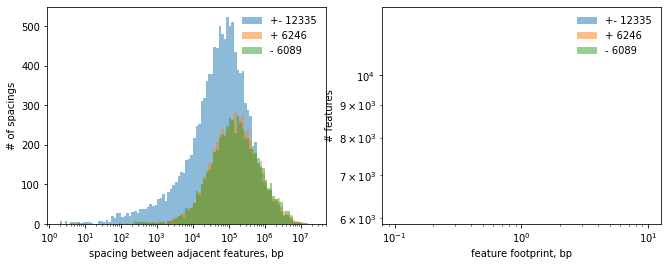

In [7]:
# calculate "spacing" between adjacent features,
# assuming coordinates are sorted !
plot_spacing_footprint_distros({"+-":df,
                               "+":df[df["strand"]=="+"],
                               "-":df[df["strand"]=="-"]
                               })
df_merged = df

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [8]:
# plot_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2","h3k4_k562","polII","h3k4_r1","mrna_ctcf","mrna_noctcf"]
plot_samples = ["ctcf_hct_nt1","ctcf_hct_nt2","ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","polII","h3k4_r1","h3k4_hct","mrna_ctcf"]

titles = plot_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in plot_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [9]:
# do all stackups with the parameters ...
stackups = {}
for s in bw_fnames:
    print(f"stacking up {s} ...")
    %time stackups[s] = rstacks( bw_fnames[s], df_merged, flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan  )

stacking up ctcf_hct_nt1 ...
CPU times: user 2.2 s, sys: 135 ms, total: 2.34 s
Wall time: 2.32 s
stacking up ctcf_hct_nt2 ...
CPU times: user 2.15 s, sys: 180 ms, total: 2.33 s
Wall time: 2.31 s
stacking up ctcf ...
CPU times: user 1.63 s, sys: 92 ms, total: 1.72 s
Wall time: 1.72 s
stacking up noctcf ...
CPU times: user 1.56 s, sys: 92.5 ms, total: 1.66 s
Wall time: 1.64 s
stacking up rad21_CTCF ...
CPU times: user 1.77 s, sys: 108 ms, total: 1.88 s
Wall time: 1.87 s
stacking up rad21_noCTCF ...
CPU times: user 1.45 s, sys: 52.3 ms, total: 1.5 s
Wall time: 1.49 s
stacking up ins_CTCF ...
CPU times: user 1.24 s, sys: 68.4 ms, total: 1.3 s
Wall time: 1.3 s
stacking up ins_noCTCF ...
CPU times: user 1.25 s, sys: 91.1 ms, total: 1.34 s
Wall time: 1.37 s
stacking up polII ...
CPU times: user 1.35 s, sys: 56.2 ms, total: 1.41 s
Wall time: 1.4 s
stacking up h3k4_r1 ...
CPU times: user 1.98 s, sys: 100 ms, total: 2.08 s
Wall time: 2.07 s
stacking up h3k4_hct ...
CPU times: user 2.45 s, sys: 1

In [10]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
aaa = rstacks(
    "gene_plus.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
bbb = rstacks(
    "gene_minus.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
stackups[feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
plot_samples.append(feat_name)
titles = plot_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

In [11]:
# turn G4-seq signal into stackup via bigBed:
annot_flank = 5_000
annot_binsize = 200
feat_name = "g4seq"
aaa = rstacks(
    "G4_polstall.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
stackups[feat_name] = aaa

    
#let's describe our samples that we want to have in Figure 1 ...
plot_samples.append(feat_name)
titles = plot_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (0,1)
cmps[s] = "Blues"
norms[s] = None

### Flip everything according to genes ...

In [12]:
flip_stackups = OrderedDict()
the_stackup = stackups
# we'll be flipping according to gene orientation ....
the_strand = df_merged["strand"]
preflip_index = the_strand.index

# flipped index according to genes ...
flip_stackup_index = np.concatenate([
    preflip_index[the_strand=="+"],
    preflip_index[the_strand=="-"],
    preflip_index[~the_strand.isin(["+","-"])] # don't forget to bring NaN-filled EVs back in
])

assert (np.sort(flip_stackup_index) == preflip_index).all()

# flip EVERYTHING according to the strand
_flip_stackups = {}
for s in bw_fnames:
    _flip_stackups[s] = np.concatenate([
        the_stackup[s][the_strand=="+"],
        (-1 if s=="gene" else 1) * the_stackup[s][the_strand=="-"][:,::-1],
        the_stackup[s][~the_strand.isin(["+","-"])] # keep NaN-filled items along unperturbed
    ])[np.argsort(flip_stackup_index)]
# !!! Make sure rows in the stackups are re-sorted back the same way
# ro ensure they are in sync with the input BED-files !

# print flip condition numbers ...
sum_p = (the_strand=="+").sum()
sum_m = (the_strand=="-").sum()
sum_n = (~the_strand.isin(["+","-"])).sum()

print(f"initial number of items {len(the_strand)}, intact {sum_p}, flipped {sum_m} , NaN-filled {sum_n}")
print(f"{sum_p} + {sum_m} + {sum_n} = {sum_p+sum_m+sum_n}")

# save flipped the_stackup to the new OrderedDict ...
flip_stackups = _flip_stackups


initial number of items 12335, intact 6246, flipped 6089 , NaN-filled 0
6246 + 6089 + 0 = 12335


### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [13]:
# normalize all of the insulation flip_stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

# subtract = "mean_top"
# subtract_size = 7
normalize_insulation_stackups_INPLACE(
    stackups_set = flip_stackups,
    ins_keys = insulation_keys
)

# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.452,-.153)
    cmps[s] = cmapYlGnBu_r

In [14]:
# length, width = flip_stackups['h3k4_r1'].shape
# center_bin = int(width/2)

# flip_stackups['K4_mean'] = np.nanmean(flip_stackups['h3k4_r1'][:,center_bin:center_bin+4],axis=1)

# initial_index = np.arange( len(flip_stackups['h3k4_r1']) )
# ks = [('K4_mean', "sort", 1, False)]
# _, jjj = recursive_data_ordering( ks, initial_index, flip_stackups, verbose=True)
# #flip_stackups['K4_mean'][jjj]

sorting 12335 elements of K4_mean into 1 groups ...


In [20]:
length, width = flip_stackups['h3k4_r1'].shape
center_bin = int(width/2)
flip_stackups['K4_mean_HAP1'] = np.nanmean(flip_stackups['h3k4_r1'][:,center_bin:center_bin+4],axis=1)
flip_stackups['K4_mean_HCT116'] = np.nanmean(flip_stackups['h3k4_hct'][:,center_bin:center_bin+4],axis=1)

### let's perform a scientific selection of the number of active TSS - as a "place" where K4_mean signal drops from to None ...

this can be done by averaging K4 over different number of bins around TSS - we concluded that -1,+1 (2 bins-wide) is too narrow, and +/-3 and +/-2 are very similar, "reliable" and smooth - and we chose +/-3 (6-200bp bins wide) for the downstream analysis ...

sorting 12335 elements of K4_mean_HCT116 into 1 groups ...


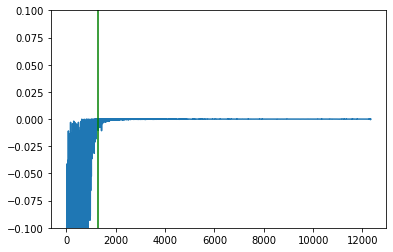

In [35]:
# sort on HCT116 ...
sorting_key = "K4_mean_HCT116"
initial_index = np.arange( len(flip_stackups['h3k4_r1']) )
ks = [(sorting_key, "sort", 1, False)]
_, jjj = recursive_data_ordering( ks, initial_index, flip_stackups, verbose=True)

# find strong ones ...
plt.plot(np.diff(flip_stackups[sorting_key][jjj]))
ax = plt.gca()
ax.set_ylim(-0.1,0.1)
ax.axvline(1300,color="green")
number_TTS_near_TSS_HCT = 1300

# save list of clean TTSs in HCT116 :
tts_hct = copy(df.loc[jjj[number_TTS_near_TSS_HCT:]].reset_index(drop=True))
tts_hct = tts_hct.sort_values(["chrom","start"])
tts_hct = tts_hct[tts_hct["chrom"].isin(autosomal_chroms)]
tts_hct = tts_hct.reset_index(drop=True)

sorting 12335 elements of K4_mean_HAP1 into 1 groups ...


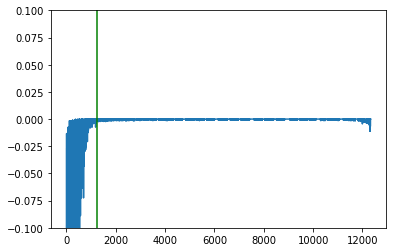

In [36]:
# sort on HAP1 ...
sorting_key = "K4_mean_HAP1"
initial_index = np.arange( len(flip_stackups['h3k4_r1']) )
ks = [(sorting_key, "sort", 1, False)]
_, jjj = recursive_data_ordering( ks, initial_index, flip_stackups, verbose=True)

# find strong ones ...
plt.plot(np.diff(flip_stackups[sorting_key][jjj]))
ax = plt.gca()
ax.set_ylim(-0.1,0.1)
ax.axvline(1250,color="green")
number_TTS_near_TSS_HAP = 1250

# save list of clean TTSs in HAP1 :
tts_hap = copy(df.loc[jjj[number_TTS_near_TSS_HAP:]].reset_index(drop=True))
tts_hap = tts_hap.sort_values(["chrom","start"])
tts_hap = tts_hap[tts_hap["chrom"].isin(autosomal_chroms)]
tts_hap = tts_hap.reset_index(drop=True)

In [38]:
# Find a list of TTS that is common between CT116 and HAP1 cell lines:
tts_common = bioframe.overlap(tts_hap, tts_hct, how="inner", suffixes=('','_')) # keep all TTS
tts_common = tts_common[["chrom","start","end","strand"]]
 # peek those, without CTCF
    
tts_common = tts_common.drop_duplicates()
tts_common = tts_common.sort_values(["chrom","start"])
tts_common = tts_common[ tts_common["chrom"].isin(autosomal_chroms) ]
tts_common = tts_common.reset_index(drop=True)

# # save it ...
# fname = f"ActiveTTS-{len(tts_common)}-1bp_HCT116_HAP1.bed"
# tts_common.to_csv(fname, index=False, header=None, sep="\t")
# print(f"saving Active TTS shared between HCT116 and HAP1 to {fname}")

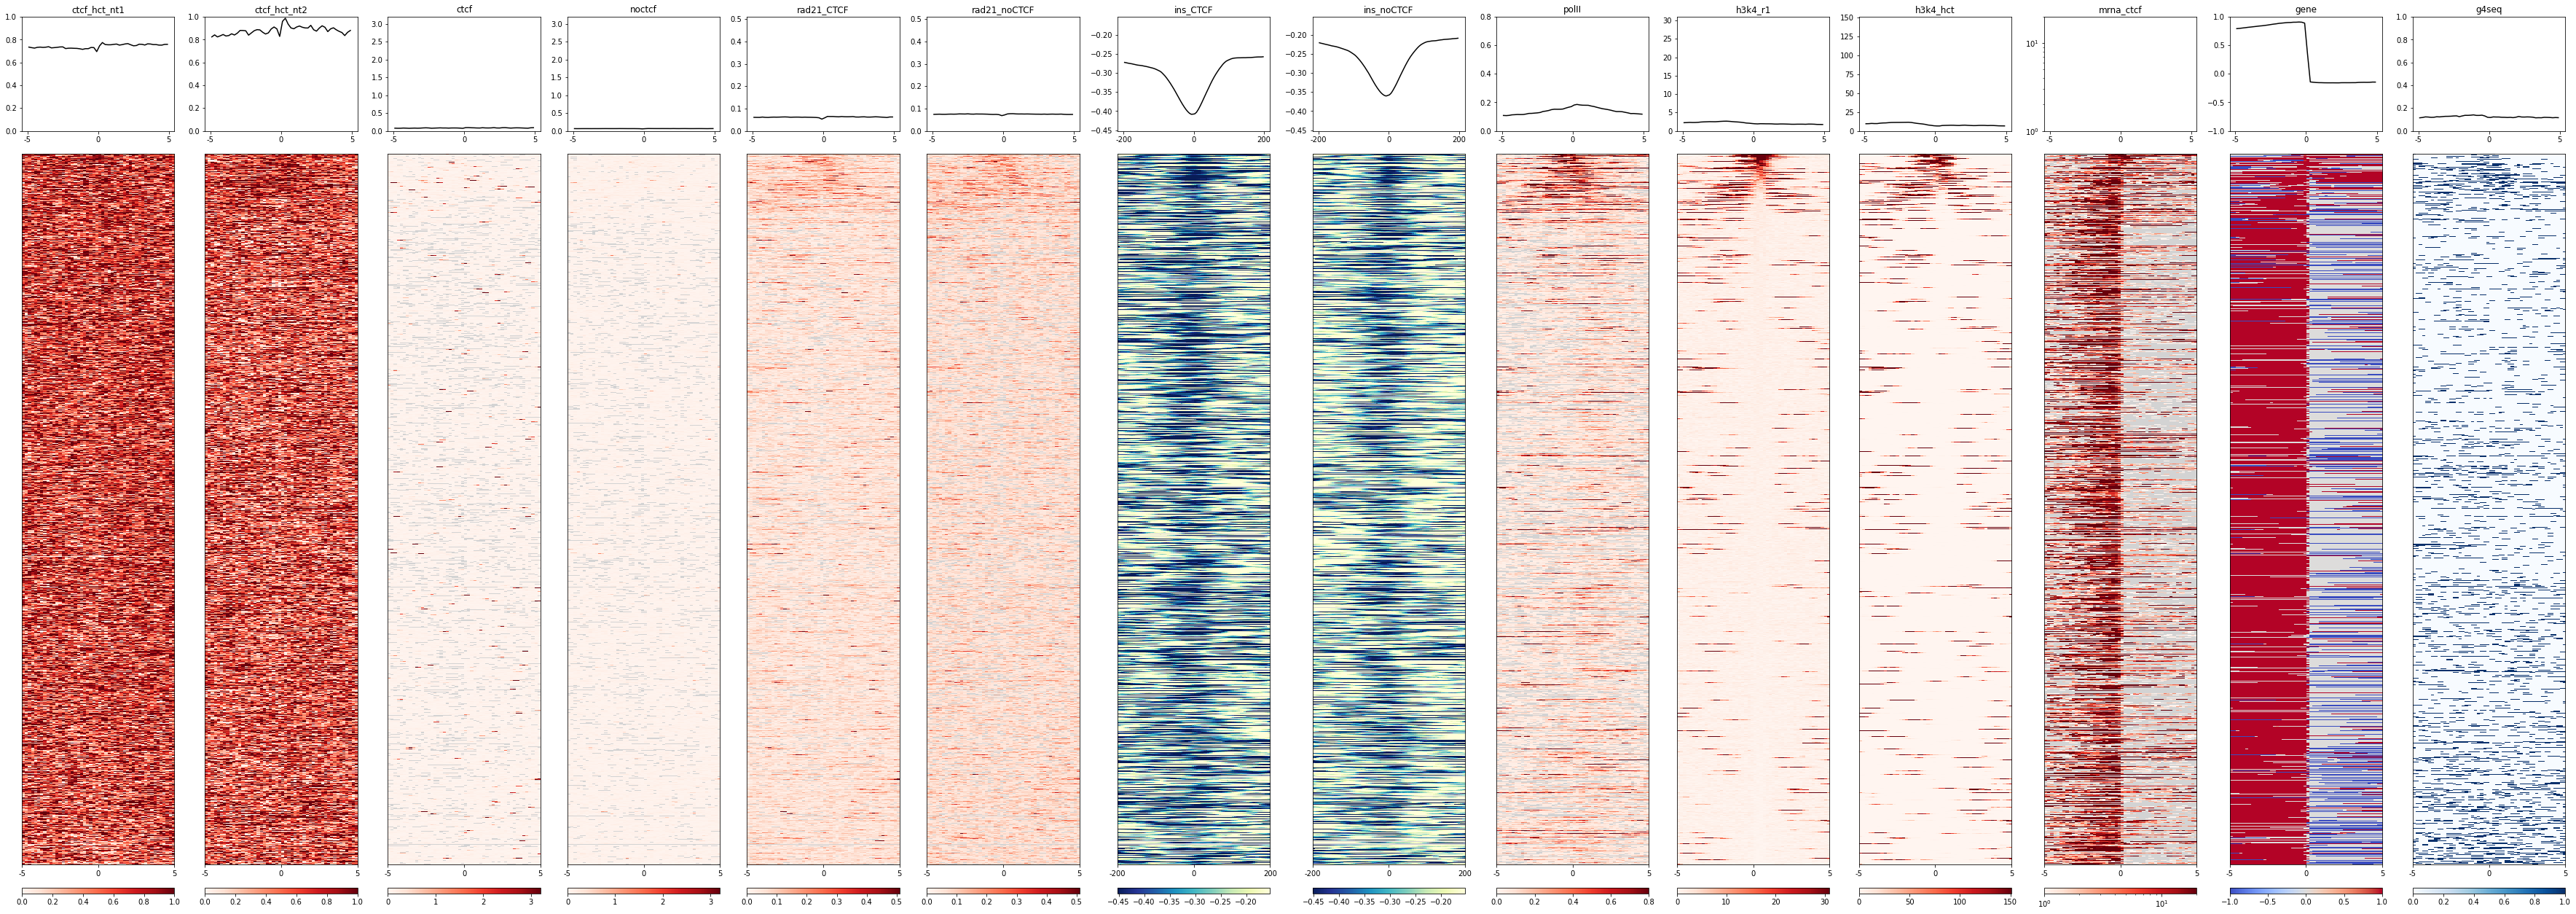

In [17]:
hmss = [ flip_stackups[_k][jjj] for _k in plot_samples ]
_limss = [ limss[_k] for _k in plot_samples ]
_cmps = [ cmps[_k] for _k in plot_samples ]
_binsizes = [ binsizes[_k] for _k in plot_samples ]
_norms = [ norms[_k] for _k in plot_samples ]

extra_order = None
hmss_order = None
xtra_axs = plot_stackups(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")

sorting 11085 elements of ctcf into 1 groups ...


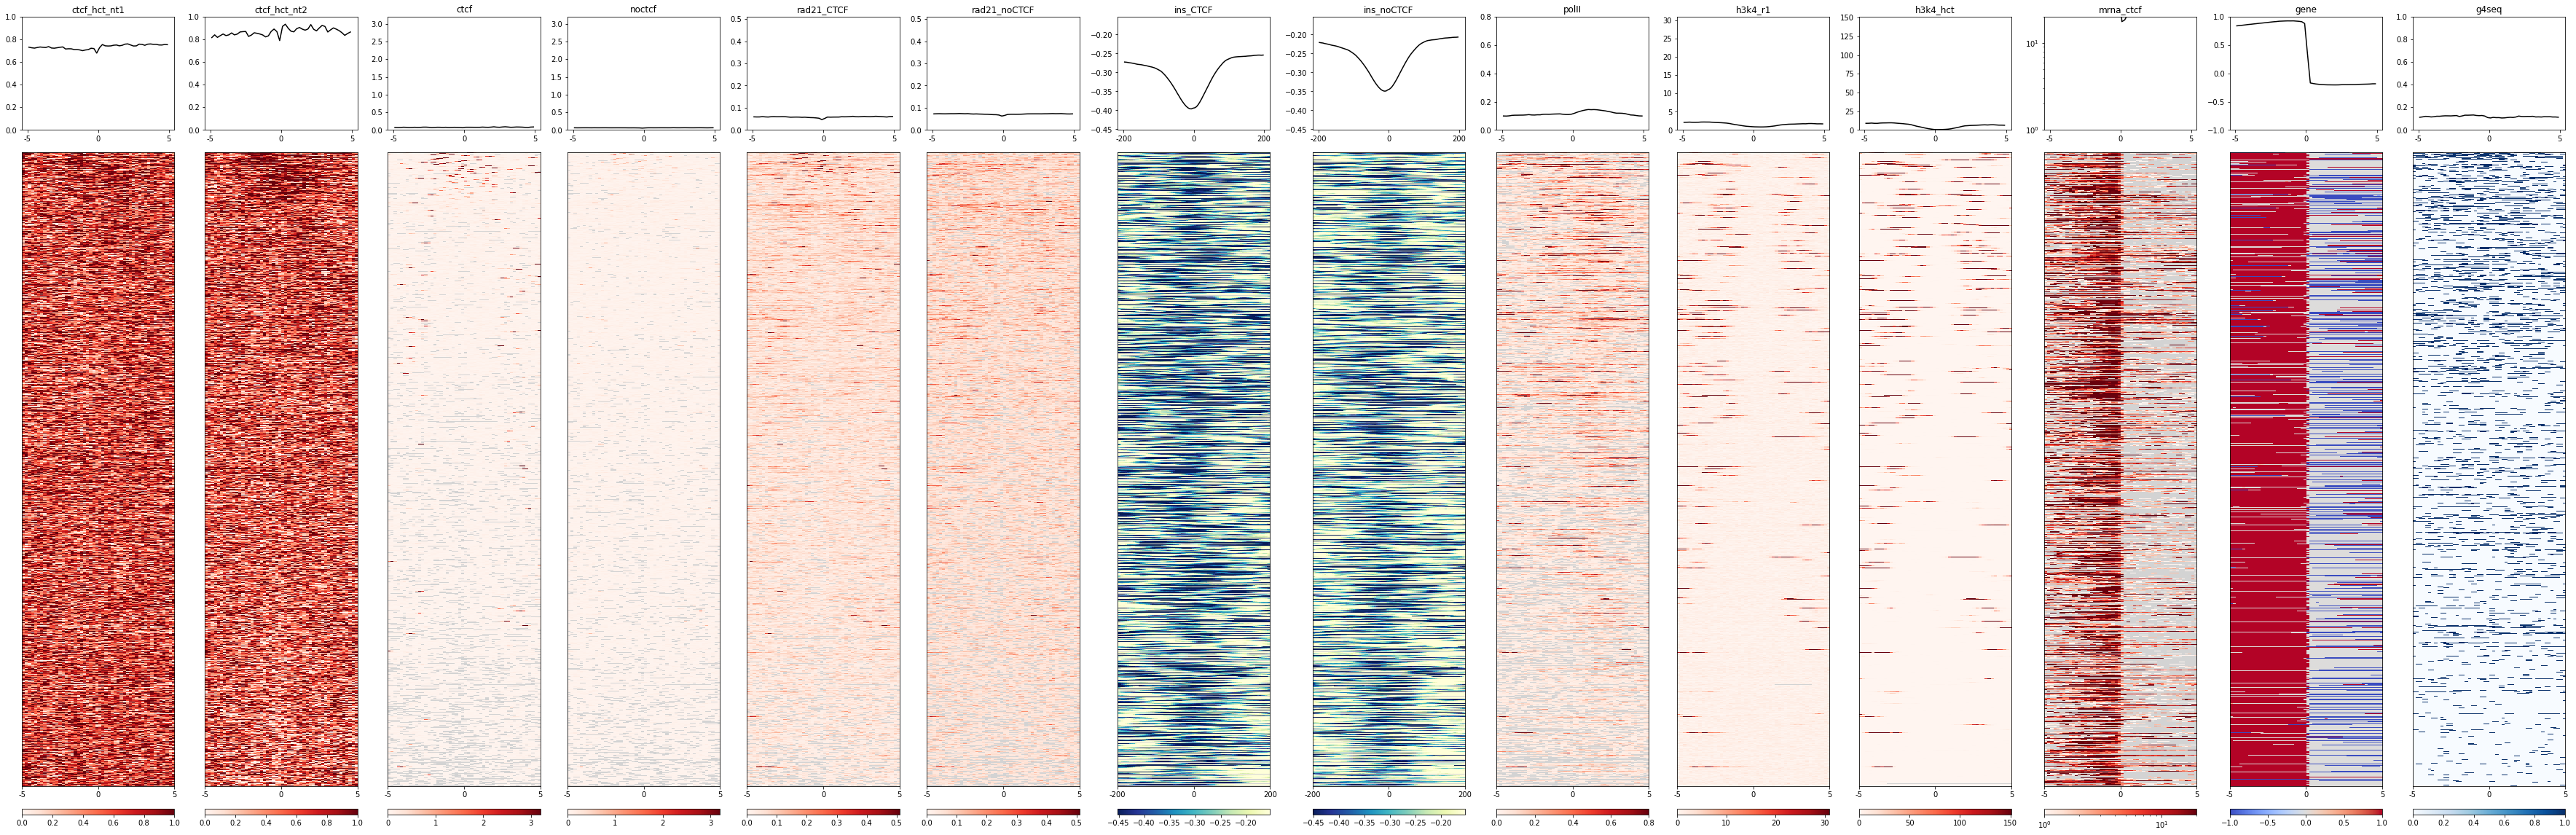

In [19]:
# let's take TTS of active genes, without H3K4 nearby ...
iii = jjj[number_TTS_near_TSS:]

_l, _w = flip_stackups['ctcf'].shape
_cent = int(_w/2)
tmp_dict = {}
tmp_dict['ctcf'] = np.nanmean(flip_stackups['ctcf'][iii,_cent-10:_cent+10],axis=1)

ks = [('ctcf', "sort", 1, False)]
_, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)

hmss = [ flip_stackups[_k][iii[iii_reord]] for _k in plot_samples ]
_limss = [ limss[_k] for _k in plot_samples ]
_cmps = [ cmps[_k] for _k in plot_samples ]
_binsizes = [ binsizes[_k] for _k in plot_samples ]
_norms = [ norms[_k] for _k in plot_samples ]

extra_order = None
hmss_order = None
xtra_axs = plot_stackups(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")

### Creating a list of active TTSs (common in HCT and HAP) without CTCF around it (in either of the cell lines) ...

In [41]:
ctcf_hct_df = bioframe.read_table(
    "CTCF_narrowPeak_HCT116_ENCODE.bed", # CTCF peaks from ENCODE for HCT116
    names=["chrom","start","end"],
    usecols=(0,1,2)
)
ctcf_hct_df = ctcf_hct_df.sort_values(["chrom","start"])
ctcf_hct_df = ctcf_hct_df[ ctcf_hct_df["chrom"].isin(autosomal_chroms) ]
ctcf_hct_df = ctcf_hct_df.reset_index(drop=True)

In [42]:
ctcf_hap_df = bioframe.read_table(
    "NT-CTCF-narrowPeaks-sort-merge", # just our NT CTCF ChipSeq peaks ...
    names=["chrom","start","end"]
)
ctcf_hap_df = ctcf_hap_df.sort_values(["chrom","start"])
ctcf_hap_df = ctcf_hap_df[ ctcf_hap_df["chrom"].isin(autosomal_chroms) ]
ctcf_hap_df = ctcf_hap_df.reset_index(drop=True)

In [43]:
_df = bioframe.overlap(ctcf_hap_df, ctcf_hct_df, how="outer", return_index=True)
_df.isna().any(axis=1)

idx2 = _df["index_2"]
idx1 = _df["index_1"]

ctcf_union_df = pd.concat([
            # get HCT indexes, whenever HAP1 is NA
            ctcf_hct_df.loc[ idx2[~idx2.isna()].astype("int") ],
            # get HAP indexes, whenever HCT is NA
            ctcf_hap_df.loc[ idx1[idx2.isna()].astype("int") ]
]).reset_index(drop=True)

ctcf_union_df = ctcf_union_df.drop_duplicates()
ctcf_union_df = ctcf_union_df.sort_values(["chrom","start"])
ctcf_union_df = ctcf_union_df[ ctcf_union_df["chrom"].isin(autosomal_chroms) ]
ctcf_union_df = ctcf_union_df.reset_index(drop=True)
ctcf_union_df


chrom      start        end
0      chr1      10151      10508
1      chr1     237582     237908
2      chr1     714001     714579
3      chr1     805227     805366
4      chr1     840108     840261
...     ...        ...        ...
54627  chr9  140960461  140960745
54628  chr9  140995492  140995776
54629  chr9  141041997  141042234
54630  chr9  141044360  141044643
54631  chr9  141073490  141073774

[54632 rows x 3 columns]

In [44]:
# using existing list of active TSSs - we expand them by 2kb on each side ... -> ddf_exp
tts_common = tts_common.sort_values(["chrom","start"])
_ddf = copy(tts_common.reset_index(drop=True))
ddf_exp = bioframe.expand(_ddf,pad=2_000)

In [46]:
# then overlap expanded TSS with CTCF -peaks, to find TSS without CTCF nearby ...
ddf_exp_ctcf = bioframe.overlap(ddf_exp,ctcf_union_df,how="left",suffixes=('','_')) # keep all TSS
# peek those, without CTCF 
_mask_TSS_without_CTCF = pd.isnull( ddf_exp_ctcf["chrom_"] )
ddf_exp_noctcf = ddf_exp_ctcf[_mask_TSS_without_CTCF][["chrom","start","end","strand"]]
ddf_exp_noctcf = ddf_exp_noctcf.astype({"start":int,"end":int})
# there shouldn't be any duplicates, but just in case ...
ddf_exp_noctcf = ddf_exp_noctcf.drop_duplicates().reset_index(drop=True)
print(f"there are {len(ddf_exp_noctcf)} TTS active in both HCT/HAP without CTCF (in either of the cell-line) ...")
# now let's undo "expand" in a an easiest way - expand with a negative pad = -2000 ...
ddf_exp_noctcf = bioframe.expand(ddf_exp_noctcf, pad=-2_000)
# make footprints are unique ! - all has to be 1 bp!
(ddf_exp_noctcf["end"]-ddf_exp_noctcf["start"]).value_counts()
# save it ...
fname = f"ActiveTTS-woH3K4-woCTCF-{len(ddf_exp_noctcf)}-1bp_HCT116_HAP1.bed"
ddf_exp_noctcf.to_csv(fname, index=False, header=None, sep="\t")
print(f"saving 'clean' TTS without CTCF nearby to {fname}")

there are 8894 TTS active in both HCT/HAP without CTCF (in either of the cell-line) ...
saving 'clean' TTS without CTCF nearby to ActiveTTS-woH3K4-woCTCF-8894-1bp_HCT116_HAP1.bed


In [24]:
# xxx = bioframe.overlap(ddf_exp_noctcf,ddf,how="left",suffixes=('1','2'))[["chrom1","start1","end1","strand1"]].drop_duplicates()
# xxx
# # xxx[~pd.isnull(xxx["chrom2"])][["chrom1","start1","end1","strand1"]].drop_duplicates()

In [25]:
# !scp ActiveTSS-11000-5bp.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# ! scp ActiveTSS-NO-CTCF-5bp.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp ActiveTSS_HAP1-G4sorted.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/